In [317]:
#Imports needed to process data, do computations, regress and visualize data
import pandas as pd
import numpy as np
import zstandard as zstd
import io
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm

In [318]:
#Referring to the data to access the folders that contain the zipped data
zst_folder_reddit = "Blockhouse/REDDIT/Into/Rdd_concat"
zst_folder_solar = "Blockhouse/Solar/Into/Solar_concat"
zst_folder_accolade = "Blockhouse/Accolade/Into/Accolade_concat"
zst_folder_ferrari = "Blockhouse/Ferrari/Into/Ferrari_concat"
zst_folder_factset = "Blockhouse/Factset/Into/Factset_concat"

folders = [zst_folder_reddit,zst_folder_solar,zst_folder_accolade,zst_folder_ferrari,zst_folder_factset]

#Exctracting zipped data and building a clean data frame with all the data for one stock concatenated
def df_clean(folder):
    dataframes = []
    for file_name in sorted(os.listdir(folder)):
        if file_name.endswith(".zst"):
            file_path = os.path.join(folder, file_name)
            with open(file_path, 'rb') as compressed_file:
                dctx = zstd.ZstdDecompressor()
                decompressed = dctx.stream_reader(compressed_file)
                df = pd.read_csv(decompressed)
                dataframes.append(df)
    
    combined_df = pd.concat(dataframes, ignore_index=True)
    #Used downloadable data for debugging
    #combined_df.to_csv(f"combined_file.csv", index=False)
    combined_df = combined_df[combined_df['side'] != 'N']
    combined_df = combined_df[combined_df['depth'] <= 5]
    return combined_df

#Building dictionaries for all stocks so that we keep results separated with different keys and reutilize previous results
reddit = {}
solar = {}
accolade = {}
ferrari = {}
factset = {}

#First addition is the full data frame coming from the concatenation of extracted data files for each stock
reddit["combined"] = df_clean(zst_folder_reddit)
solar["combined"] = df_clean(zst_folder_solar)
accolade["combined"] = df_clean(zst_folder_accolade)
ferrari["combined"] = df_clean(zst_folder_ferrari)
factset["combined"] = df_clean(zst_folder_factset)


In [319]:
#Computing the order flows for bids and asks
def calculate_of(df):
    #splitting data into asks and bids as order flows are computed differently for each side
    bids = df[df['side'] == "B"].copy()
    asks = df[df['side'] == "A"].copy()
    #shifting the data allows me to get the previous price needed in the formula on the same row
    bids['previous_price'] = bids['price'].shift(1)
    bids['previous_size'] = bids['size'].shift(1)
    asks['previous_price'] = asks['price'].shift(1)
    asks['previous_size'] = asks['size'].shift(1)
    
    def calculate_bid(row):
        #Applicating the formula mentioned in section 2.1 of the article
        if pd.isna(row['previous_price']):
            return 0 
        if row['price'] > row['previous_price']:
            return row['size']
        elif row['price'] == row['previous_price']:
            return row['size'] - row['previous_size']
        else:
            return -row['size']
    def calculate_ask(row):
        #Applicating the formula mentioned in section 2.1 of the article
        if pd.isna(row['previous_price']):
            return 0 
        if row['price'] > row['previous_price']:
            return -row['size']
        elif row['price'] == row['previous_price']:
            return row['size'] - row['previous_size']
        else:
            return row['size']
    #Returning both data frames as bids and asks are separated often in the following calculus
    bids['OF_b'] = bids.apply(calculate_bid, axis=1)
    asks['OF_a'] = asks.apply(calculate_ask, axis=1)
    return bids, asks

#Storing the results in the dictionaries to keep a modularized code
reddit['bids'], reddit['asks'] = calculate_of(reddit['combined'])
solar['bids'], solar['asks'] = calculate_of(solar['combined'])
accolade['bids'], accolade['asks'] = calculate_of(accolade['combined'])
ferrari['bids'], ferrari['asks'] = calculate_of(ferrari['combined'])
factset['bids'], factset['asks'] = calculate_of(factset['combined'])

In [320]:
#Computing here the first level OFI for each minute in the time frame
def ofi_v1(bids, asks):
    bids['ts_event'] = pd.to_datetime(bids['ts_event'])
    asks['ts_event'] = pd.to_datetime(asks['ts_event'])
    bids['minute'] = bids['ts_event'].dt.floor('T')
    asks['minute'] = asks['ts_event'].dt.floor('T')
    #Summing all bids and asks happening in the same minute at the same depth separately
    bids_sum = bids.groupby(['minute', 'depth'])['OF_b'].sum()
    asks_sum = asks.groupby(['minute', 'depth'])['OF_a'].sum()
    #Substracting asks sum from bids sum
    ofi_result = bids_sum.subtract(asks_sum, fill_value=0).reset_index(name='OFI')
    return ofi_result

#Storing the results in the dictionaries to keep a modularized code
reddit['ofi_v1'] = ofi_v1(reddit['bids'], reddit['asks'])
solar['ofi_v1'] = ofi_v1(solar['bids'], solar['asks'])
accolade['ofi_v1'] = ofi_v1(accolade['bids'], accolade['asks'])
ferrari['ofi_v1'] = ofi_v1(ferrari['bids'], ferrari['asks'])
factset['ofi_v1'] = ofi_v1(factset['bids'], factset['asks'])

/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/1779927415.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bids['minute'] = bids['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/1779927415.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  asks['minute'] = asks['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/1779927415.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bids['minute'] = bids['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/1779927415.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  asks['minute'] = asks['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/1779927

In [321]:
#Computing here the normalised OFI for each minute in the time frame
def ofi_v2(ofi_v1,bids,asks):
    ofi_list_per_depth = ofi_v1.groupby('depth').agg({'OFI': list}).reset_index()
    ofi_list_per_depth.columns = ['depth', 'OFI_per_minute']
    bids['total_size'] = bids['size']
    asks['total_size'] = asks['size']
    combined = pd.concat([bids, asks])
    #Counting number of events per minute
    event_counts = combined.groupby('minute').size().reset_index(name='num_events')
    
    size_per_minute_depth = combined.groupby(['minute', 'depth'])['total_size'].sum().reset_index()
    size_per_minute_depth = size_per_minute_depth.merge(event_counts, on='minute')
    size_per_minute_depth['normalized_size'] = size_per_minute_depth['total_size'] / (2 * size_per_minute_depth['num_events'])

    #Calculating Q_M_h (average normalized size per minute)
    qm_h = size_per_minute_depth.groupby('minute')['normalized_size'].mean().reset_index(name='Q_M_h')

    merged_df = ofi_v1.merge(qm_h, on='minute', how='outer')
    merged_df['OFI_normalized'] = merged_df['OFI'] / merged_df['Q_M_h']
    result_df = merged_df[['minute', 'depth', 'OFI_normalized']]
    return result_df


#Storing the results in the dictionaries to keep a modularized code
reddit['ofi_normalized'] = ofi_v2(reddit['ofi_v1'],reddit['bids'],reddit['asks'])
solar['ofi_normalized'] = ofi_v2(solar['ofi_v1'],solar['bids'],solar['asks'])
accolade['ofi_normalized'] = ofi_v2(accolade['ofi_v1'],accolade['bids'],accolade['asks'])
ferrari['ofi_normalized'] = ofi_v2(ferrari['ofi_v1'],ferrari['bids'],ferrari['asks'])
factset['ofi_normalized'] = ofi_v2(factset['ofi_v1'],factset['bids'],factset['asks'])

In [322]:
def PCA_ofi(ofi_norm):
    depth_ofi_df = ofi_norm.pivot(index='minute', columns='depth', values='OFI_normalized')
    depth_ofi_df.columns = [f'depth_{col}' for col in depth_ofi_df.columns]
    depth_ofi_df = depth_ofi_df.fillna(0)
    depth_ofi_df = (depth_ofi_df - depth_ofi_df.mean()) / depth_ofi_df.std()
    #Initializing PCA 
    pca = PCA(n_components=1)
    pca.fit(depth_ofi_df)
    #Extracting first  component identified by PCA
    w1 = pca.components_[0]
    w1_normalized = w1 / np.sum(np.abs(w1))

    #Normalizing and Integrating previous results
    result_df = pd.DataFrame({
        'Integrated_OFI': np.dot(depth_ofi_df.values, w1_normalized)
    }, index=depth_ofi_df.index)
    
    result_df = result_df.reset_index()
    
    return result_df

#Storing the results in the dictionaries to keep a modularized code
reddit['PCA vector'] = PCA_ofi(reddit['ofi_normalized'])
solar['PCA vector'] = PCA_ofi(solar['ofi_normalized'])
accolade['PCA vector'] = PCA_ofi(accolade['ofi_normalized'])
ferrari['PCA vector'] = PCA_ofi(ferrari['ofi_normalized'])
factset['PCA vector'] = PCA_ofi(factset['ofi_normalized'])
print(reddit['PCA vector'])

                        minute  Integrated_OFI
0    2024-12-04 09:01:00+00:00       -0.053336
1    2024-12-04 09:02:00+00:00        0.046239
2    2024-12-04 09:03:00+00:00       -0.026213
3    2024-12-04 09:04:00+00:00       -0.046246
4    2024-12-04 09:05:00+00:00       -0.093058
...                        ...             ...
3354 2024-12-10 23:51:00+00:00       -0.034158
3355 2024-12-10 23:53:00+00:00       -0.055321
3356 2024-12-10 23:54:00+00:00       -0.055881
3357 2024-12-10 23:55:00+00:00       -0.017232
3358 2024-12-10 23:56:00+00:00       -0.041021

[3359 rows x 2 columns]


In [323]:
for stock in [reddit['PCA vector'], ferrari['PCA vector'], solar['PCA vector'], accolade['PCA vector'], factset['PCA vector']]:
    print(f"Min: {stock['Integrated_OFI'].min():.2f}")
    print(f"Max: {stock['Integrated_OFI'].max():.2f}")
    print(f"Mean: {stock['Integrated_OFI'].mean():.20f}")
    print(f"Std: {stock['Integrated_OFI'].std():.2f}\n")

Min: -3.50
Max: 4.81
Mean: 0.00000000000000002961
Std: 0.53

Min: -4.58
Max: 4.96
Mean: 0.00000000000000009539
Std: 0.54

Min: -7.72
Max: 8.50
Mean: 0.00000000000000000626
Std: 0.52

Min: -5.32
Max: 5.36
Mean: -0.00000000000000002378
Std: 0.53

Min: -3.66
Max: 3.73
Mean: -0.00000000000000002020
Std: 0.48



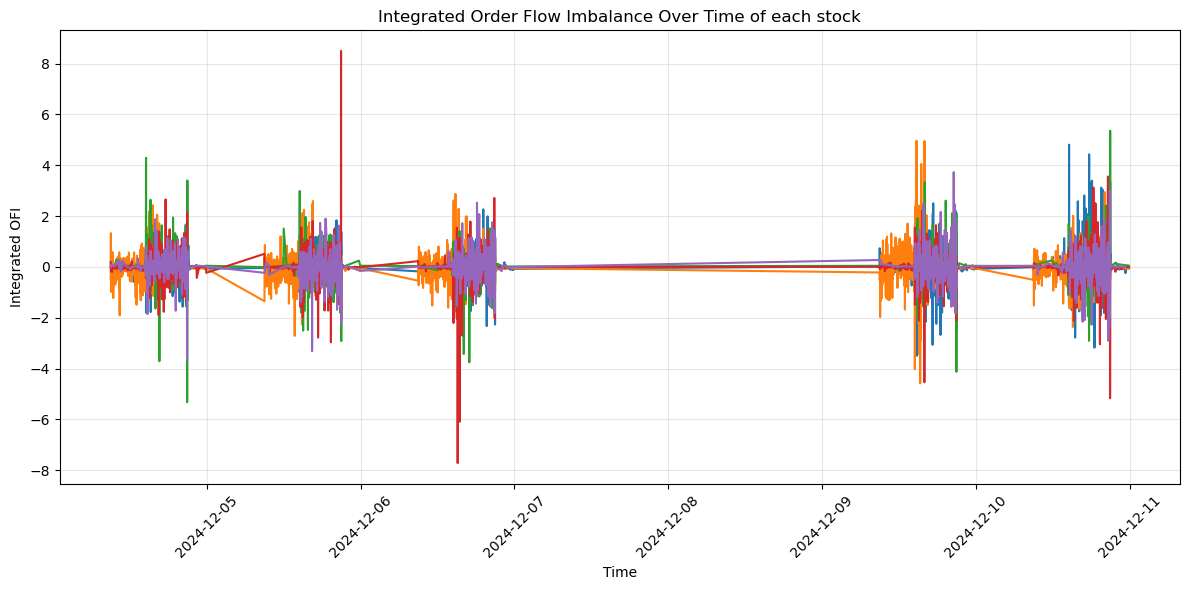

In [324]:
#Plotting time series
plt.figure(figsize=(12, 6))
plt.plot(reddit['PCA vector']['minute'], reddit['PCA vector']['Integrated_OFI'])
plt.plot(ferrari['PCA vector']['minute'], ferrari['PCA vector']['Integrated_OFI'], label='Ferrari')
plt.plot(accolade['PCA vector']['minute'], accolade['PCA vector']['Integrated_OFI'], label='Ferrari')
plt.plot(solar['PCA vector']['minute'], solar['PCA vector']['Integrated_OFI'], label='Ferrari')
plt.plot(factset['PCA vector']['minute'], factset['PCA vector']['Integrated_OFI'], label='Ferrari')


#The goal of the graph is to get a perspective of each stock's OFI with the others
plt.title('Integrated Order Flow Imbalance Over Time of each stock')
plt.xlabel('Time')
plt.ylabel('Integrated OFI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)

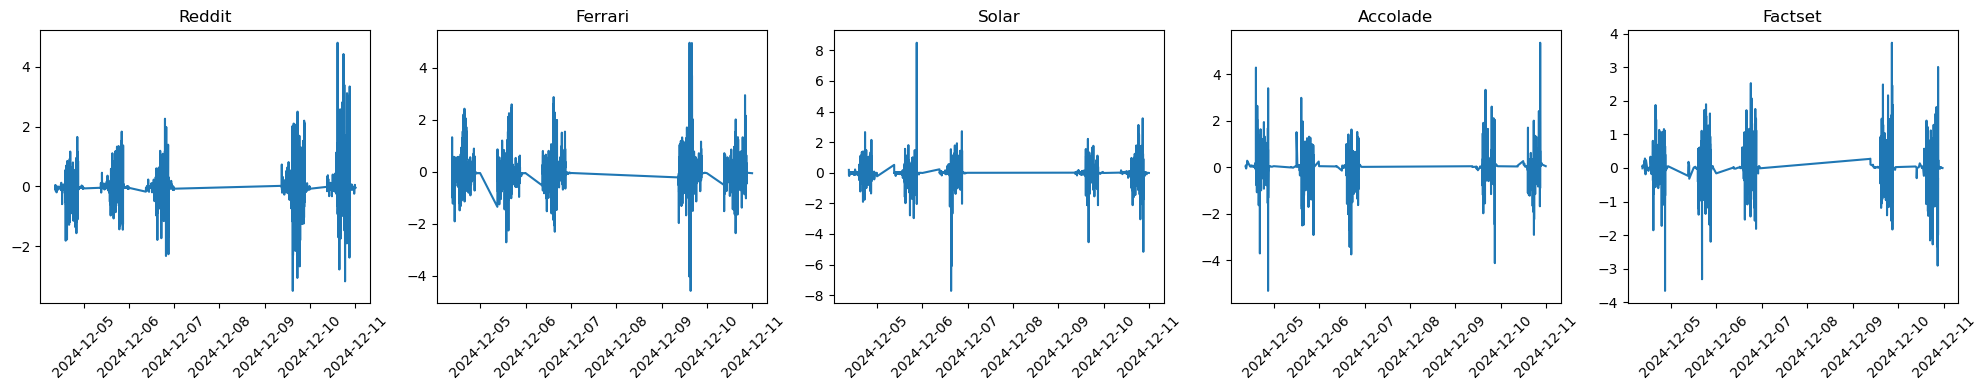

In [325]:
#Plotting each stock for more readibility
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].plot(reddit['PCA vector']['minute'], reddit['PCA vector']['Integrated_OFI'])
axs[0].set_title('Reddit')

axs[1].plot(ferrari['PCA vector']['minute'], ferrari['PCA vector']['Integrated_OFI'])
axs[1].set_title('Ferrari')

axs[2].plot(solar['PCA vector']['minute'], solar['PCA vector']['Integrated_OFI'])
axs[2].set_title('Solar')

axs[3].plot(accolade['PCA vector']['minute'], accolade['PCA vector']['Integrated_OFI'])
axs[3].set_title('Accolade')

axs[4].plot(factset['PCA vector']['minute'], factset['PCA vector']['Integrated_OFI'])
axs[4].set_title('Factset')

for ax in axs:
   ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

In [326]:
def returns(bids, asks, df):
   #Extracting all minutes for bids and asks to keep data frame of the same lengths
   bids['minute'] = bids['ts_event'].dt.floor('T')
   asks['minute'] = asks['ts_event'].dt.floor('T')
   all_minutes = pd.concat([bids['minute'], asks['minute']]).unique()
   
   #Limiting ourselves to the depth 0 corresponding to the first level as precised in the mid price definition
   bids_0 = bids[bids['depth'] == 0]
   asks_0 = asks[asks['depth'] == 0]
   
   #Creating pivot tables
   bid_prices = bids_0.pivot_table(index='minute', values='price', aggfunc='mean')
   bid_prices.columns = ['bid_price']
   ask_prices = asks_0.pivot_table(index='minute', values='price', aggfunc='mean')
   ask_prices.columns = ['ask_price']
   

   complete_df = pd.DataFrame(index=all_minutes)
   complete_df.index.name = 'minute'
   
   #Handling missing values to not loose line and keep data frame length identical accross results
   complete_df = complete_df.join(bid_prices, how='left').join(ask_prices, how='left')
   complete_df = complete_df.fillna(method='ffill')
   
   #Calculating mid price
   complete_df['mid_price'] = complete_df.apply(
       lambda row: row['bid_price'] if row['ask_price'] == 0 
       else row['ask_price'] if row['bid_price'] == 0
       else (row['bid_price'] + row['ask_price']) / 2, 
       axis=1
   )
   
   #Calculating returns
   complete_df['mid_price_shifted'] = complete_df['mid_price'].shift(1)
   complete_df['returns'] = np.where(
       (complete_df['mid_price'] == 0) | (complete_df['mid_price_shifted'] == 0),
       0,
       np.log(complete_df['mid_price']/complete_df['mid_price_shifted'])
   )
   
   return complete_df.reset_index()[['minute', 'mid_price', 'mid_price_shifted', 'returns']]

#Storing the results in the dictionaries to keep a modularized code
reddit['returns'] = returns(reddit['bids'], reddit['asks'], reddit['combined'])
solar['returns'] = returns(solar['bids'], solar['asks'], solar['combined'])
accolade['returns'] = returns(accolade['bids'], accolade['asks'], accolade['combined'])
ferrari['returns'] = returns(ferrari['bids'], ferrari['asks'], ferrari['combined'])
factset['returns'] = returns(factset['bids'], factset['asks'], factset['combined'])
print(reddit['returns'])

/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bids['minute'] = bids['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  asks['minute'] = asks['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  complete_df = complete_df.fillna(method='ffill')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bids['minute'] = bids['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r00

                        minute   mid_price  mid_price_shifted   returns
0    2024-12-04 09:01:00+00:00  141.706250                NaN       NaN
1    2024-12-04 09:03:00+00:00  148.259375         141.706250  0.045207
2    2024-12-04 09:04:00+00:00  148.721875         148.259375  0.003115
3    2024-12-04 09:05:00+00:00  191.512500         148.721875  0.252875
4    2024-12-04 09:06:00+00:00  193.205000         191.512500  0.008799
...                        ...         ...                ...       ...
3354 2024-12-10 23:33:00+00:00  157.343750         157.343750  0.000000
3355 2024-12-10 23:42:00+00:00  157.343750         157.343750  0.000000
3356 2024-12-10 23:47:00+00:00  157.343750         157.343750  0.000000
3357 2024-12-10 23:49:00+00:00  157.343750         157.343750  0.000000
3358 2024-12-10 23:56:00+00:00  157.343750         157.343750  0.000000

[3359 rows x 4 columns]


/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  complete_df = complete_df.fillna(method='ffill')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bids['minute'] = bids['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  asks['minute'] = asks['ts_event'].dt.floor('T')
/var/folders/z4/zxdz2ppx30n0y4g1k_m7777r0000gn/T/ipykernel_87319/79531082.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  complete_df = complete_df.fillna(method='ffill')


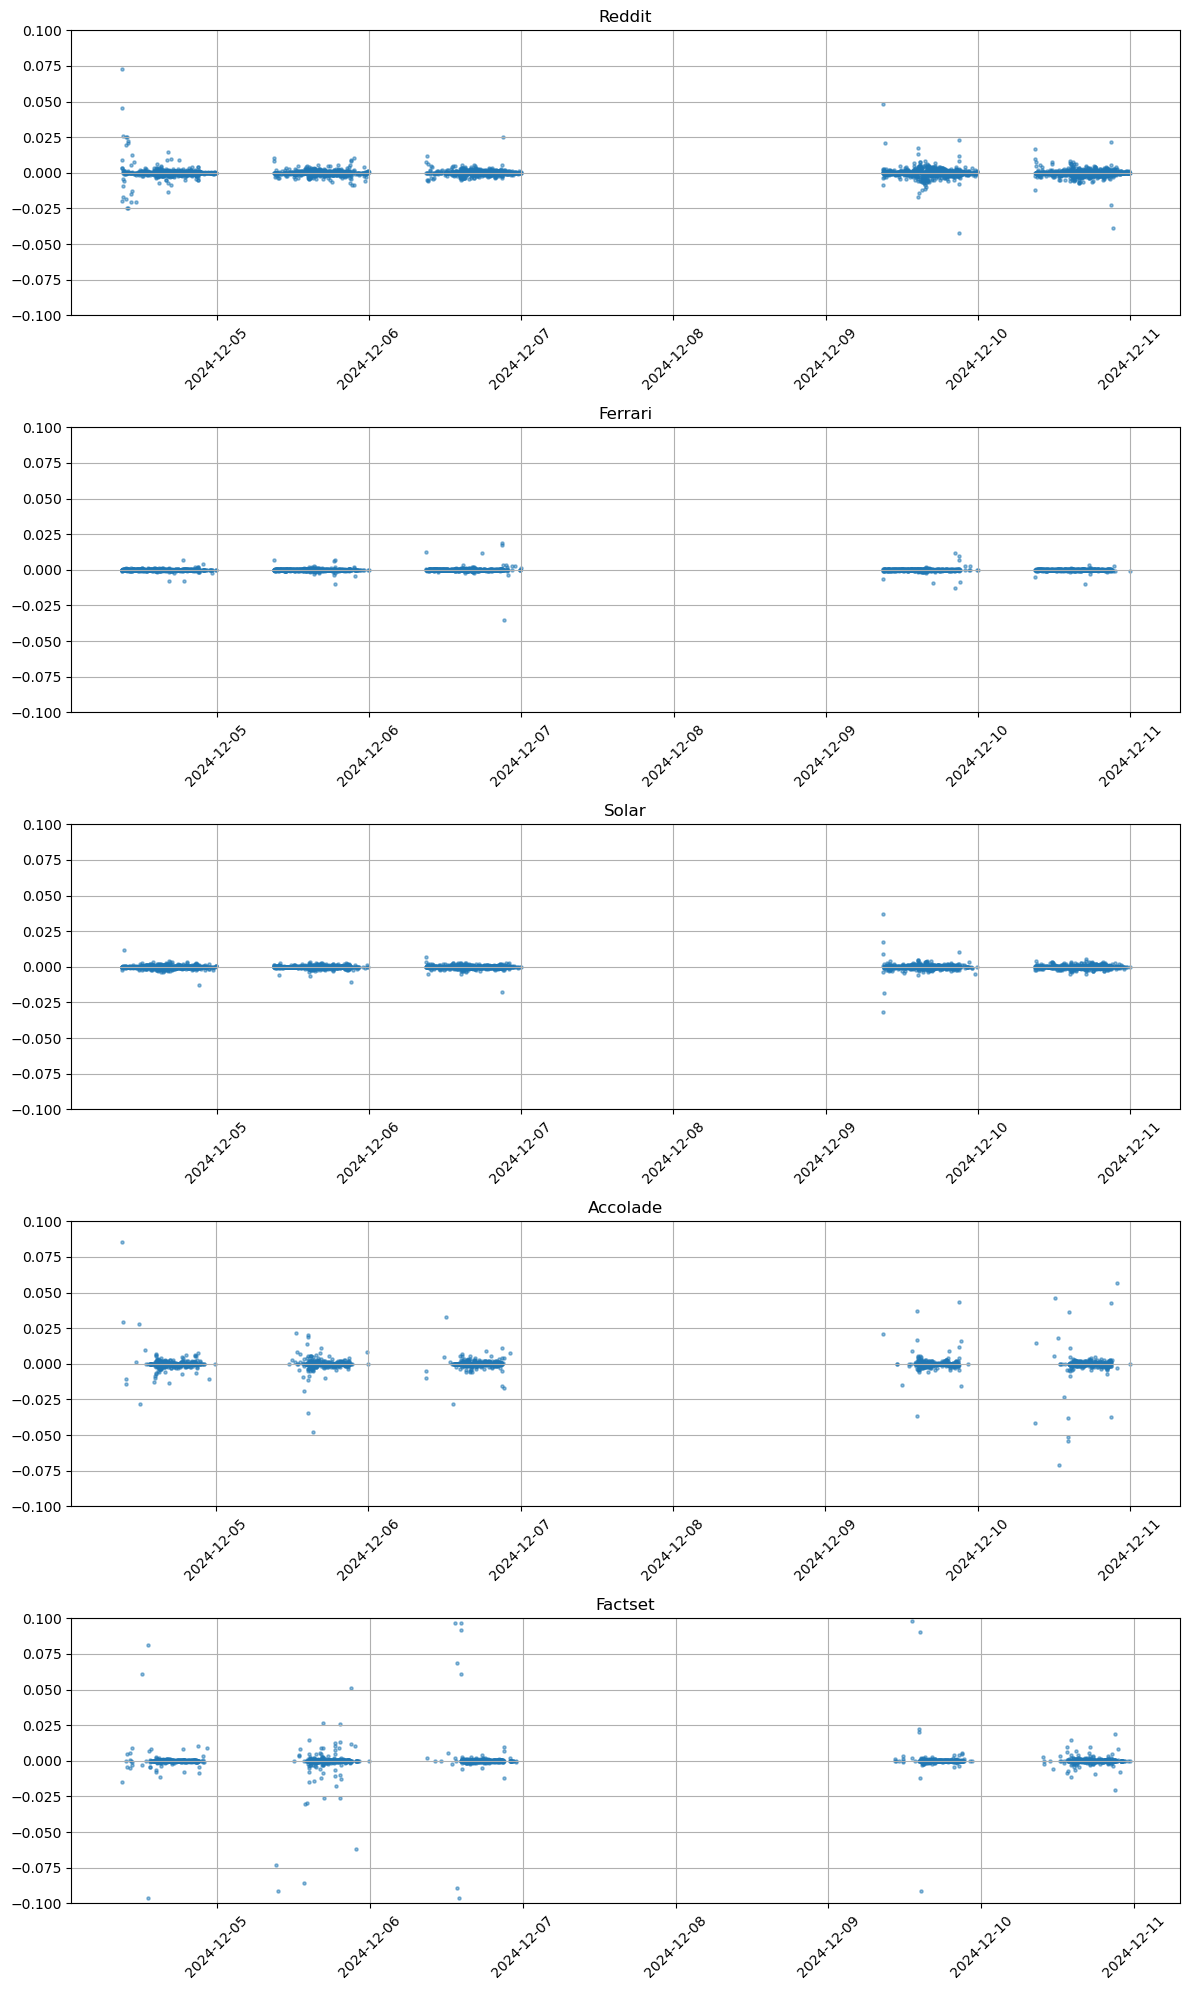

In [327]:
#Visualizing the returns for each stocks
fig, axs = plt.subplots(5, 1, figsize=(12, 20))

stocks = [reddit, ferrari, solar, accolade, factset]
titles = ['Reddit', 'Ferrari', 'Solar', 'Accolade', 'Factset']

for ax, stock, title in zip(axs, stocks, titles):
   ax.scatter(stock['returns']['minute'], stock['returns']['returns'], s=5, alpha=0.5)
   ax.set_title(title)
   ax.set_ylim(-0.1, 0.1)
   ax.grid(True)
   ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

In [328]:
#Checking the Overall mean to verify coherence of results
mean_ofi = reddit['returns']['returns'].mean()
print(f"Overall mean: {mean_ofi}")

reddit['returns']['returns'].describe()

Overall mean: 3.1172319642680094e-05


count    3358.000000
mean        0.000031
std         0.009454
min        -0.249065
25%        -0.000746
50%         0.000000
75%         0.000802
max         0.252875
Name: returns, dtype: float64

In [329]:
#Building linear regression model using OLS
def price_impact(returns, integrated_ofi):
    data_OLS = pd.merge(returns, integrated_ofi, on='minute', suffixes=('_returns', '_ofi'))
    data_cleaned = data_OLS.dropna(subset=['Integrated_OFI', 'returns'])
    print(data_cleaned.head())

    #Predicting returns using Integrated_OFI
    y = data_cleaned['returns']
    X = data_cleaned['Integrated_OFI']
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    print(model.summary())

    #Extracting alpha and Beta
    alpha = model.params['const']
    beta = model.params['Integrated_OFI']
    
    print(f"Intercept (α): {alpha}")
    print(f"Slope (β): {beta}")
    
    
    residuals = model.resid

    return alpha, beta, model, residuals.mean()

#Storing the results in the dictionaries to keep a modularized code
reddit['alpha'],reddit['beta'],reddit['model'],reddit['residuals'] = price_impact(reddit['returns'], reddit['PCA vector'])
solar['alpha'],solar['beta'],solar['model'],solar['residuals'] = price_impact(solar['returns'], solar['PCA vector'])
accolade['alpha'],accolade['beta'],accolade['model'],accolade['residuals'] = price_impact(accolade['returns'], accolade['PCA vector'])
ferrari['alpha'],ferrari['beta'],ferrari['model'],ferrari['residuals'] = price_impact(ferrari['returns'], ferrari['PCA vector'])
factset['alpha'],factset['beta'],factset['model'],factset['residuals'] = price_impact(factset['returns'], factset['PCA vector'])


                     minute   mid_price  mid_price_shifted   returns  \
1 2024-12-04 09:03:00+00:00  148.259375         141.706250  0.045207   
2 2024-12-04 09:04:00+00:00  148.721875         148.259375  0.003115   
3 2024-12-04 09:05:00+00:00  191.512500         148.721875  0.252875   
4 2024-12-04 09:06:00+00:00  193.205000         191.512500  0.008799   
5 2024-12-04 09:07:00+00:00  193.838750         193.205000  0.003275   

   Integrated_OFI  
1       -0.026213  
2       -0.046246  
3       -0.093058  
4       -0.049044  
5       -0.049044  
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     12.60
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           0.000392
Time:                        04:07:05   Log-Likeliho

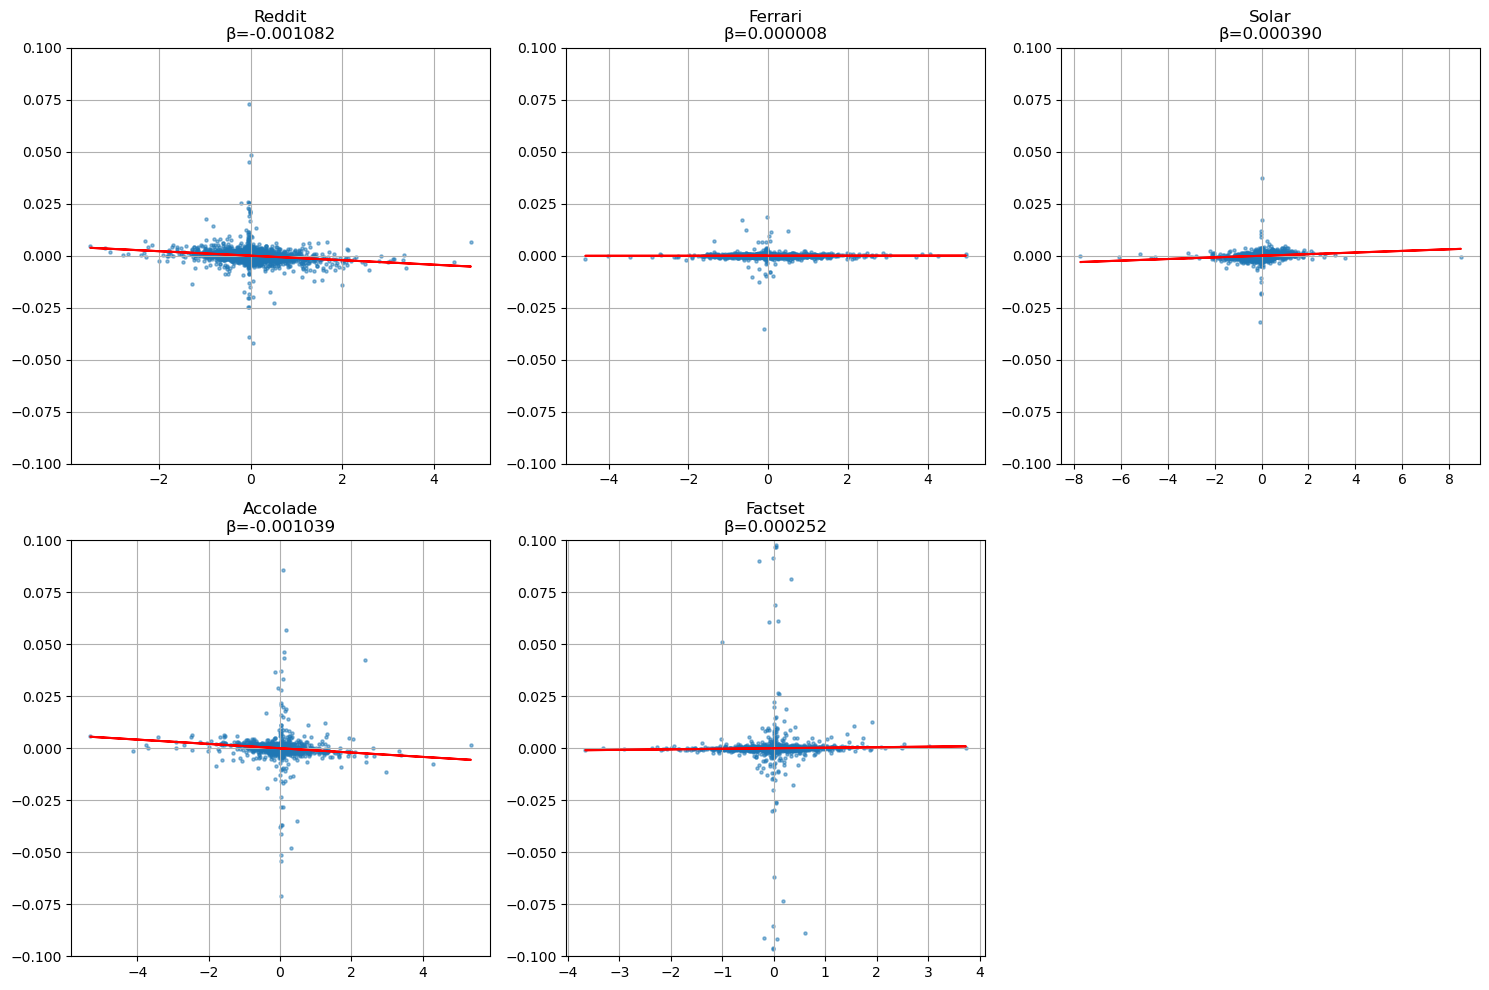

In [330]:
#Visualizing returns vs OFI with fitted regression lines for each stock
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
stocks = [reddit, ferrari, solar, accolade, factset]
titles = ['Reddit', 'Ferrari', 'Solar', 'Accolade', 'Factset']

for i, (stock, title) in enumerate(zip(stocks, titles)):
   row = i // 3
   col = i % 3
   
   if i < 5: 
       data = pd.merge(stock['returns'], stock['PCA vector'], on='minute')
       axs[row, col].scatter(data['Integrated_OFI'], data['returns'], alpha=0.5, s=5)
       axs[row, col].plot(data['Integrated_OFI'], 
                         stock['alpha'] + stock['beta'] * data['Integrated_OFI'], 
                         color='red')
       axs[row, col].set_title(f'{title}\nβ={stock["beta"]:.6f}')
       axs[row, col].grid(True)
       axs[row, col].set_ylim(-0.1, 0.1)

fig.delaxes(axs[1,2])
plt.tight_layout()

In [331]:
#Rebuilding data to ease processing
reddit_data = pd.merge(
    reddit['returns'][['minute', 'returns']], 
    reddit['PCA vector'][['minute', 'Integrated_OFI']], 
    on='minute', how='inner'
)
ferrari_data = pd.merge(
    ferrari['returns'][['minute', 'returns']], 
    ferrari['PCA vector'][['minute', 'Integrated_OFI']], 
    on='minute', how='inner'
)
accolade_data = pd.merge(
    accolade['returns'][['minute', 'returns']], 
    accolade['PCA vector'][['minute', 'Integrated_OFI']], 
    on='minute', how='inner'
)
factset_data = pd.merge(
    factset['returns'][['minute', 'returns']], 
    factset['PCA vector'][['minute', 'Integrated_OFI']], 
    on='minute', how='inner'
)
solar_data = pd.merge(
    solar['returns'][['minute', 'returns']], 
    solar['PCA vector'][['minute', 'Integrated_OFI']], 
    on='minute', how='inner'
)

#Combining all data
data = pd.merge(reddit_data.rename(columns={'returns': 'returns_reddit', 'Integrated_OFI': 'ofi_reddit'}),
                ferrari_data.rename(columns={'returns': 'returns_ferrari', 'Integrated_OFI': 'ofi_ferrari'}),
                on='minute', how='inner')
data = pd.merge(data, accolade_data.rename(columns={'returns': 'returns_accolade', 'Integrated_OFI': 'ofi_accolade'}),
                on='minute', how='inner')
data = pd.merge(data, factset_data.rename(columns={'returns': 'returns_factset', 'Integrated_OFI': 'ofi_factset'}),
                on='minute', how='inner')
data = pd.merge(data, solar_data.rename(columns={'returns': 'returns_solar', 'Integrated_OFI': 'ofi_solar'}),
                on='minute', how='inner')

data = data.dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:         returns_reddit   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.176
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           0.000101
Time:                        04:07:51   Log-Likelihood:                 7272.9
No. Observations:                1993   AIC:                        -1.453e+04
Df Residuals:                    1987   BIC:                        -1.450e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      1.304   

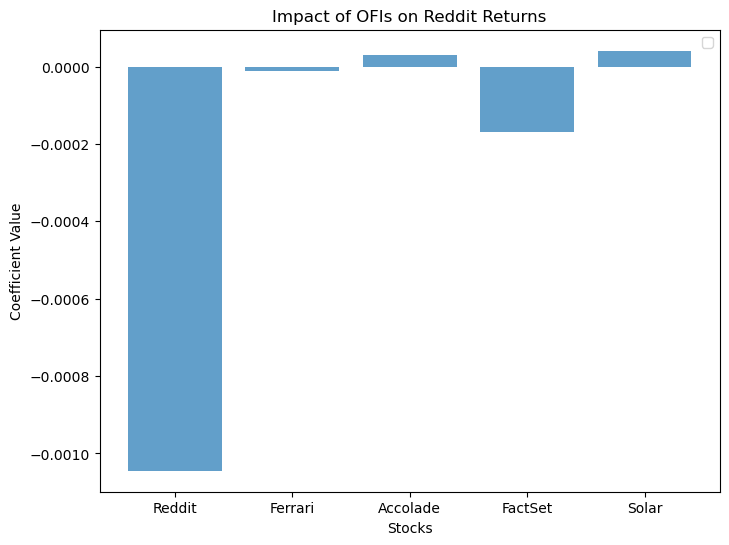

In [332]:
# Runing regressions using Cross-impact of best-level OFIs of all stocks for reddit
y = data['returns_reddit']
X = data[['ofi_reddit', 'ofi_ferrari', 'ofi_accolade', 'ofi_factset', 'ofi_solar']]
X = sm.add_constant(X)

model_reddit = sm.OLS(y, X).fit()
print(model_reddit.summary())

coefficients = model_reddit.params[1:]
stock_labels = ['Reddit', 'Ferrari', 'Accolade', 'FactSet', 'Solar']

plt.figure(figsize=(8, 6))
plt.bar(stock_labels, coefficients, alpha=0.7)
plt.title('Impact of OFIs on Reddit Returns')
plt.xlabel('Stocks')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:          returns_solar   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     22.14
Date:                Wed, 08 Jan 2025   Prob (F-statistic):           1.19e-21
Time:                        04:07:52   Log-Likelihood:                 10738.
No. Observations:                1993   AIC:                        -2.146e+04
Df Residuals:                    1987   BIC:                        -2.143e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.523e-05   2.49e-05     -1.816   

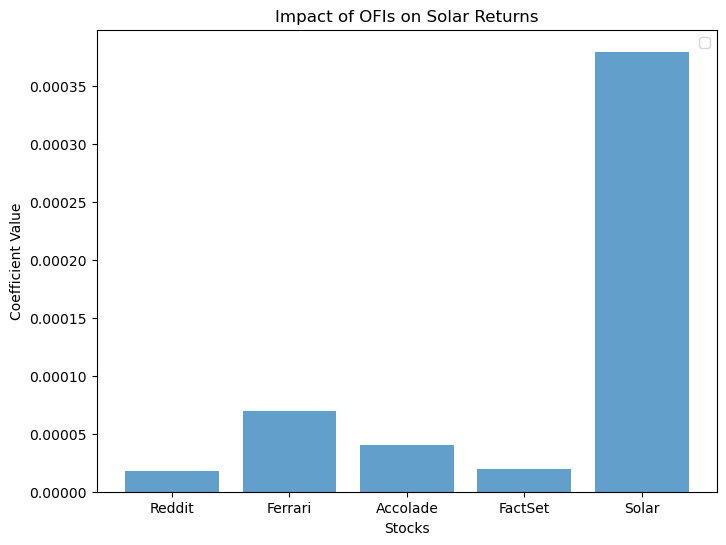

In [333]:
# Runing regressions using Cross-impact of best-level OFIs of all stocks for solar
y = data['returns_solar']
X = data[['ofi_reddit', 'ofi_ferrari', 'ofi_accolade', 'ofi_factset', 'ofi_solar']]
X = sm.add_constant(X)

model_solar = sm.OLS(y, X).fit()
print(model_solar.summary())
coefficients = model_solar.params[1:]
stock_labels = ['Reddit', 'Ferrari', 'Accolade', 'FactSet', 'Solar']

plt.figure(figsize=(8, 6))
plt.bar(stock_labels, coefficients, alpha=0.7)
plt.title('Impact of OFIs on Solar Returns')
plt.xlabel('Stocks')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:       returns_accolade   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7883
Date:                Wed, 08 Jan 2025   Prob (F-statistic):              0.558
Time:                        04:07:53   Log-Likelihood:                 6561.2
No. Observations:                1993   AIC:                        -1.311e+04
Df Residuals:                    1987   BIC:                        -1.308e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.525e-06      0.000     -0.012   

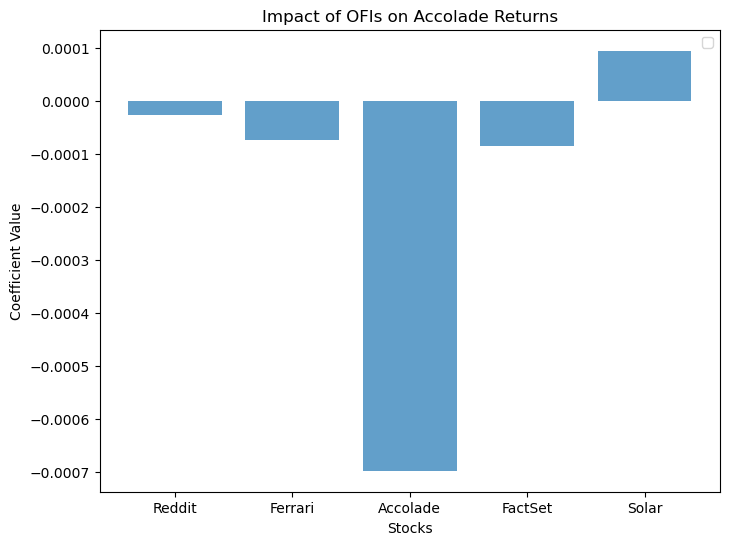

In [334]:
# Runing regressions using Cross-impact of best-level OFIs of all stocks for accolade
y = data['returns_accolade']
X = data[['ofi_reddit', 'ofi_ferrari', 'ofi_accolade', 'ofi_factset', 'ofi_solar']]
X = sm.add_constant(X)

model_accolade = sm.OLS(y, X).fit()
print(model_accolade.summary())
coefficients = model_accolade.params[1:]
stock_labels = ['Reddit', 'Ferrari', 'Accolade', 'FactSet', 'Solar']

plt.figure(figsize=(8, 6))
plt.bar(stock_labels, coefficients, alpha=0.7)
plt.title('Impact of OFIs on Accolade Returns')
plt.xlabel('Stocks')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:        returns_ferrari   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7267
Date:                Wed, 08 Jan 2025   Prob (F-statistic):              0.603
Time:                        04:07:53   Log-Likelihood:                 10875.
No. Observations:                1993   AIC:                        -2.174e+04
Df Residuals:                    1987   BIC:                        -2.170e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.382e-06   2.33e-05      0.231   

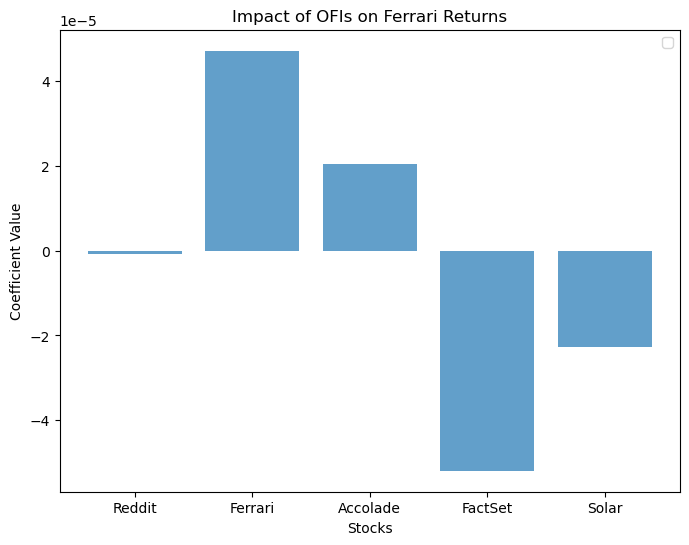

In [335]:
# Runing regressions using Cross-impact of best-level OFIs of all stocks for Ferrari
y = data['returns_ferrari']
X = data[['ofi_reddit', 'ofi_ferrari', 'ofi_accolade', 'ofi_factset', 'ofi_solar']]
X = sm.add_constant(X)

model_ferrari = sm.OLS(y, X).fit()
print(model_ferrari.summary())
coefficients = model_ferrari.params[1:]
stock_labels = ['Reddit', 'Ferrari', 'Accolade', 'FactSet', 'Solar']

plt.figure(figsize=(8, 6))
plt.bar(stock_labels, coefficients, alpha=0.7)
plt.title('Impact of OFIs on Ferrari Returns')
plt.xlabel('Stocks')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:        returns_factset   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3385
Date:                Wed, 08 Jan 2025   Prob (F-statistic):              0.890
Time:                        04:07:54   Log-Likelihood:                 5182.4
No. Observations:                1993   AIC:                        -1.035e+04
Df Residuals:                    1987   BIC:                        -1.032e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.587   

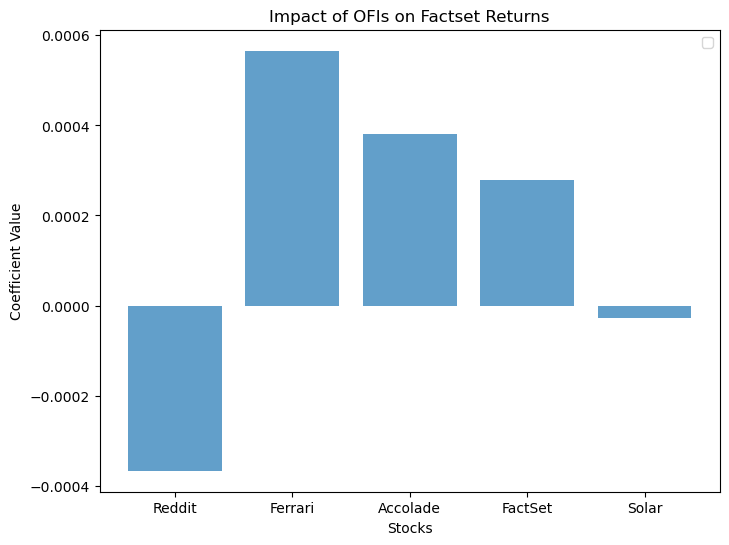

In [336]:
# Runing regressions using Cross-impact of best-level OFIs of all stocks for Factset
y = data['returns_factset']
X = data[['ofi_reddit', 'ofi_ferrari', 'ofi_accolade', 'ofi_factset', 'ofi_solar']]
X = sm.add_constant(X)

model_factset = sm.OLS(y, X).fit()
print(model_factset.summary())
coefficients = model_factset.params[1:]
stock_labels = ['Reddit', 'Ferrari', 'Accolade', 'FactSet', 'Solar']

plt.figure(figsize=(8, 6))
plt.bar(stock_labels, coefficients, alpha=0.7)
plt.title('Impact of OFIs on Factset Returns')
plt.xlabel('Stocks')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()